# This notebook shows our implementation of the paper 'Detecting and Repairing Arbitrage in Option Price Data'.
## The goal is to take option price data from Yahoo Finance and use the characterisation of static arbitrage as a set of linear constraints to formulate a linear program that we wish to solve. We then use linear optimisation to "minimally" perturb the option prices to obtain arbitrage-free prices.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
from transform_option_data import option_price_data, normaliser, D
import constraints as cs
import build_LP as bLP
import LP_norms as norms

## We use our option_price_data function, which takes option price data from Yahoo Finance for a given stock, and transforms it into a rectangular grid of prices for a set of maturities and strikes.

In [7]:
S, maturities_frac, option_prices, option_bid, option_ask, strikes = option_price_data('TSLA')

In [8]:
option_prices.head()

,195.0,200.0,210.0,220.0,230.0,240.0,250.0,260.0,270.0,280.0,290.0
4,41.0,35.925,25.95,16.725,8.925,3.875,1.365,0.475,0.195,0.095,0.055
11,41.1,36.175,26.8,18.225,11.3,6.15,3.02,1.415,0.69,0.365,0.21
18,41.875,37.125,28.125,20.225,13.2,8.025,4.55,2.5,1.39,0.805,0.505
25,42.5,37.875,28.95,20.925,14.675,9.525,5.85,3.5,2.08,1.265,0.8
32,43.2,38.55,29.875,22.425,15.875,10.675,6.9,4.3,2.68,1.7,1.105


## We then use the normaliser function to normalise the call option prices by the forward price and the corresponding discount factor.

In [5]:
option_prices_norm, option_bid_norm, option_ask_norm, strikes_norm = normaliser(S, maturities_frac, option_prices, option_bid, option_ask, strikes)

In [6]:
option_prices_norm.head()

,0.0,175.0,185.0,190.0,195.0,200.0,210.0,220.0,230.0,240.0,250.0,260.0,270.0,280.0
0,1,0.257469,0.211054,0.189074,0.168587,0.143406,0.108301,0.058792,0.018139,0.000021,0.000021,0.000021,0.000021,0.0
7,1,0.255219,0.211723,0.188163,0.167268,0.146692,0.104369,0.068229,0.034114,0.013539,0.004691,0.001791,0.000874,0.00049
14,1,0.256168,0.213988,0.192153,0.171595,0.150931,0.110669,0.075625,0.045588,0.02567,0.013101,0.007136,0.003451,0.002066
21,1,0.255093,0.214972,0.194539,0.173893,0.155482,0.115255,0.083115,0.05353,0.03331,0.019688,0.011196,0.006705,0.003938
28,1,0.258061,0.216911,0.196283,0.177676,0.15843,0.120471,0.089423,0.06199,0.040937,0.026157,0.015737,0.009548,0.006444


## Here we plot the corresponding call option price surface.

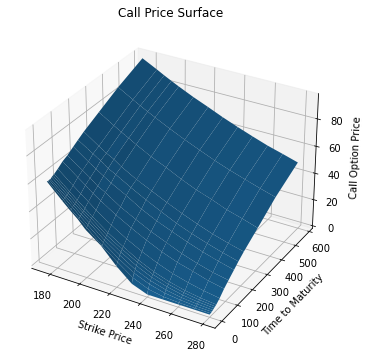

In [7]:
option_prices = option_prices.astype(float)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
ax.set_title('Call Price Surface')
YY = option_prices.index
XX = option_prices.columns
XX, YY = np.meshgrid(XX, YY)
ZZ = option_prices.values
surf = ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1)

ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Call Option Price')

plt.show()

## We use the violation_count function from constraints.py to show how many violations there of the linear constraints that characterise static arbitrage. 

In [8]:
cs.violation_count(option_prices_norm, strikes_norm)

Number of outright violations: 0
Number of vertical spread violations: 0
Number of vertical butterfly violations: 35
Number of calendar spread violations: 5
Number of calendar vertical spread violations: 8
Number of calendar butterfly violations: 135


## We use the build_Abc function to construct a matrix A, vector b, and vector c which will form our linear programming problem.

In [9]:
A, b, c = bLP.build_Abc(strikes_norm, option_prices_norm)

## We then use the l1 function written by the authors of the original paper to run the linear program optimsation with the l1-norm: this function returns the optimal perturbation vector $\epsilon$ which we can add to the call options prices to obtain the arbitrage-free prices.

In [10]:
epsilon = norms.l1(A, b.flatten(), c, solver='glpk')

In [11]:
new_prices = c + epsilon
call_prices_l1_norm = pd.DataFrame(index=maturities_frac,columns=strikes_norm.columns,data=new_prices.reshape((len(maturities_frac),len(strikes_norm.columns))))
call_prices_l1 = call_prices_l1_norm.apply(lambda x: x/D(x.index)*S, axis=0)

## After running the violation_count on the new prices, we see there are no longer any violations.

In [12]:
cs.violation_count(call_prices_l1_norm, strikes_norm)

Number of outright violations: 0
Number of vertical spread violations: 0
Number of vertical butterfly violations: 0
Number of calendar spread violations: 0
Number of calendar vertical spread violations: 0
Number of calendar butterfly violations: 0


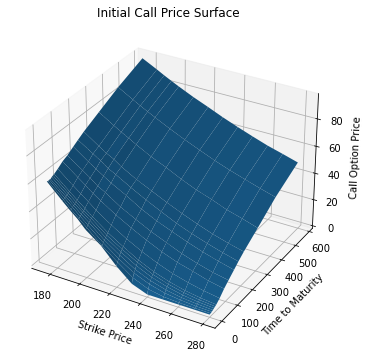

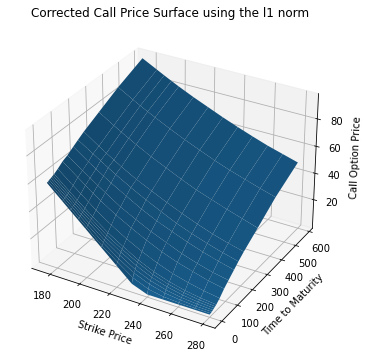

In [13]:
call_prices_l1 = call_prices_l1.astype(float)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
ax.set_title('Initial Call Price Surface ')
YY = option_prices.index
XX = option_prices.columns
XX, YY = np.meshgrid(XX, YY)
ZZ = option_prices.values
surf = ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1)

ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Call Option Price')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
ax.set_title('Corrected Call Price Surface using the l1 norm')
YY = call_prices_l1.iloc[:, 1:].index
XX = call_prices_l1.iloc[:, 1:].columns
XX, YY = np.meshgrid(XX, YY)
ZZ = call_prices_l1.iloc[:, 1:].values
surf = ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1)

ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Call Option Price')

plt.show()

## We used the following function to obtain the stress-test results in our report, following the ideas mentioned by the authors. Here we show an example with $\lambda$ = 0.15 and $\sigma$ = 0.15. The report contains results for a range of different values.

In [14]:
def stress_test(A, b, arb_free_prices, lda, sigma):
    N=len(arb_free_prices.values.flatten())
    n_perturbation=int(lda*N)
    x=np.zeros(N)
    positions=np.random.choice(np.arange(N), n_perturbation, replace=False)
    x[positions]=np.random.normal(0, sigma, n_perturbation)
    x=np.exp(x)
    
    perturbed_prices=pd.DataFrame(index=arb_free_prices.index,columns=strikes,data=(arb_free_prices.values.flatten()*x).reshape((len(arb_free_prices.index),len(arb_free_prices.columns))))
    perturbed_prices_norm=perturbed_prices.apply(lambda x: x*D(x.index)/S, axis=0)
    perturbed_prices_norm.insert(loc=0, column=0.0, value=[1]*len(perturbed_prices_norm.index))

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(projection='3d')
    ax.set_title('Perturbed surface of call price with gaussian noise')
    YY = perturbed_prices.index
    XX = perturbed_prices.columns
    XX, YY = np.meshgrid(XX, YY)
    ZZ = perturbed_prices.values
    surf = ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1)
    
    ax.set_xlabel('Strike Price')
    ax.set_ylabel('Time to Maturity')
    ax.set_zlabel('Call Option Price')
    plt.show()

    cs.violation_count(perturbed_prices_norm, strikes_norm)
    
    A, b, c = bLP.build_Abc(strikes_norm, option_prices_norm)
    epsilon = norms.l1(A, b.flatten(), c, solver='glpk')
    new_prices = c + epsilon
    new_prices_l1_norm = pd.DataFrame(index=maturities_frac,columns=strikes_norm.columns,data=new_prices.reshape((len(maturities_frac),len(strikes_norm.columns))))
    new_prices_l1 = new_prices_l1_norm.apply(lambda x: x/D(x.index)*S, axis=0)
    
    new_prices_l1 = new_prices_l1.astype(float)
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(projection='3d')
    ax.set_title('Corrected Call Price Surface using the l1 norm')
    YY = call_prices_l1.iloc[:, 1:].index
    XX = call_prices_l1.iloc[:, 1:].columns
    XX, YY = np.meshgrid(XX, YY)
    ZZ = call_prices_l1.iloc[:, 1:].values
    surf = ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1)

    ax.set_xlabel('Strike Price')
    ax.set_ylabel('Time to Maturity')
    ax.set_zlabel('Call Option Price')
    plt.show()
    
    cs.violation_count(new_prices_l1_norm, strikes_norm)
    

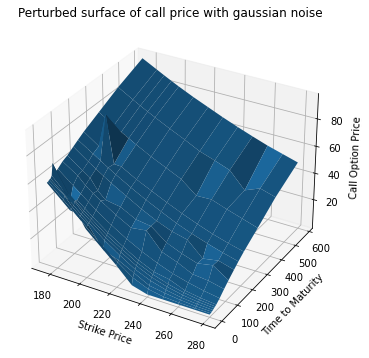

Number of outright violations: 0
Number of vertical spread violations: 7
Number of vertical butterfly violations: 30
Number of calendar spread violations: 13
Number of calendar vertical spread violations: 34
Number of calendar butterfly violations: 408


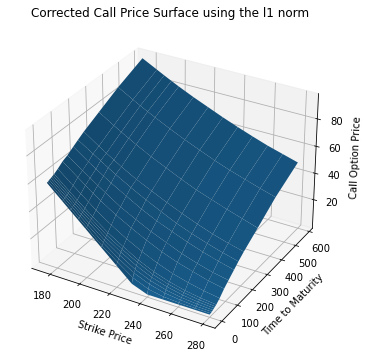

Number of outright violations: 0
Number of vertical spread violations: 0
Number of vertical butterfly violations: 0
Number of calendar spread violations: 0
Number of calendar vertical spread violations: 0
Number of calendar butterfly violations: 0


In [16]:
stress_test(A, b, call_prices_l1.iloc[:, 1:], 0.15, 0.15)

## Changing to OOP

In [42]:
class CallSurface:
    def __init__(self, ticker='None'):
        self.ticker = ticker
        self.S, self.maturities_frac, self.option_prices, self.option_bid, self.option_ask, self.strikes = option_price_data(ticker)
        
    def normalise(self):
        self.option_prices, self.option_bid, self.option_ask, self.strikes = normaliser(self.S, self.maturities_frac,
                                                                                   self.option_prices, self.option_bid, 
                                                                                    self.option_ask, self.strikes)
        self.option_prices = self.option_prices.astype(float)
        self.option_bid = self.option_bid.astype(float)
        self.option_ask = self.option_ask.astype(float)
    
    
    def violation_count(self, prices='midprice'):
    """
    Counts number of times the prices violate the static arbitrage constraints.
    Pass in 'midprice', 'bid', 'ask' to specify which prices to use.
    """
    df_strikes = self.strikes
    if prices == 'midprice'
        df_prices = self.option_prices
    elif prices == 'bid'
        df_prices = self.option_bid
    else:
        df_prices = self.option_ask
        
    v1,v2,v3,v4,v5=v_1(df_prices),v_2(df_prices,df_strikes),v_3(df_prices,df_strikes),v_4(df_prices,df_strikes),v_5(df_prices,df_strikes)
    v6=v_6_a(df_prices,df_strikes)+v_6_b(df_prices,df_strikes)
    print("Number of outright violations: "+ str(v1))
    print("Number of vertical spread violations: "+ str(v2))
    print("Number of vertical butterfly violations: "+ str(v3))
    print("Number of calendar spread violations: "+ str(v4))
    print("Number of calendar vertical spread violations: "+ str(v5))
    print("Number of calendar butterfly violations: "+ str(v6))
    

In [43]:
tsla_call_surface = CallSurface('TSLA')

In [44]:
tsla_call_surface.option_prices


,195.0,200.0,210.0,220.0,230.0,240.0,250.0,260.0,270.0,280.0,290.0
4,41.0,35.925,25.95,16.725,8.925,3.875,1.365,0.475,0.195,0.095,0.055
11,41.1,36.175,26.8,18.225,11.3,6.15,3.02,1.415,0.69,0.365,0.21
18,41.875,37.125,28.125,20.225,13.2,8.025,4.55,2.5,1.39,0.805,0.505
25,42.5,37.875,28.95,20.925,14.675,9.525,5.85,3.5,2.08,1.265,0.8
32,43.2,38.55,29.875,22.425,15.875,10.675,6.9,4.3,2.68,1.7,1.105
39,44.025,39.2,31.075,23.8,17.875,12.75,8.65,5.725,3.975,2.615,1.775
53,45.35,41.75,32.95,26.125,20.225,15.075,10.975,7.85,5.55,3.95,2.81
81,49.15,45.15,37.875,30.9,25.575,20.525,16.25,12.75,9.925,7.7,6.0
109,52.375,48.125,41.175,34.775,29.45,24.025,19.7,16.025,12.95,10.45,8.4
144,55.65,51.925,44.9,38.775,33.85,28.95,24.525,20.7,17.4,14.575,12.2


In [45]:
tsla_call_surface.normalise()